In [1]:
import pickle
import rospy
import baxter_interface
import os.path as path
import copy
from tqdm import tqdm_notebook as tqdmn
import matplotlib.pyplot as plt
import itertools
import numpy as np
import time

In [2]:
# initialize ros node
rospy.init_node('trajectory_player')
limb = baxter_interface.Limb('right')

In [3]:
# define relevant variables
PLAYBACK_MODE = 'bend'
REACH_TIME = 0.05
file_seed = path.expanduser('~/data/moveit_data/')
if PLAYBACK_MODE == 'bend':
    moveit_file = file_seed + 'bend_dof_'
else:
    file_seed = file_seed + 'full_dof_'
limb.set_joint_position_speed(0.75)

In [4]:
# in a loop load all the plans and replay
joint_angles = {}
err = []
xaxis = []
# observations = []
for file_iter in tqdmn(xrange(50), desc='Files read:'):
    plan = pickle.load(open(moveit_file + str(file_iter) + '.pkl', 'rb'))
    ctr = 0
    err.append(dict())
    err[file_iter] = {'s1':[], 'e1': [], 'w1':[]}
    obs = []
    for ctr in tqdmn(xrange(len(plan)), desc='Waypoints achieved:'):
        if ctr == 0:
            joint_names = copy.deepcopy(plan[ctr])
#             print joint_names
        else:
            current_velocities = limb.joint_velocities()
            current_torques = limb.joint_efforts()
            for (i, joint) in enumerate(joint_names):
                joint_angles[joint] = plan[ctr][i]
            if ctr == 1:
                limb.move_to_joint_positions(joint_angles)
            else:
                start_time = time.time()
                while ((time.time() - start_time) < REACH_TIME):
                    limb.set_joint_positions(joint_angles)
            measured_angles = limb.joint_angles()
            err[file_iter]['e1'].append(measured_angles['right_e1']-joint_angles['right_e1'])
            err[file_iter]['s1'].append(measured_angles['right_s1']-joint_angles['right_s1'])
            err[file_iter]['w1'].append(measured_angles['right_w1']-joint_angles['right_w1'])
            # append all dicts to a list
#     observations.append(obs)
#     xaxis.append(xrange(len(plan)-1))
#     plt.plot(xaxis, err['e1']*180/np.pi, 'b')
#     plt.plot(xaxis, err['s1']*180/np.pi, 'r')
#     plt.plot(xaxis, err['w1']*180/np.pi, 'g')
#     plt.show()

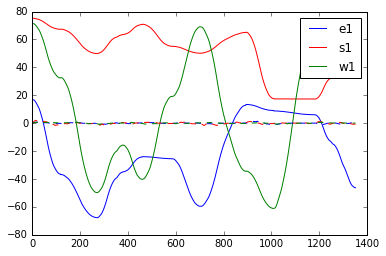

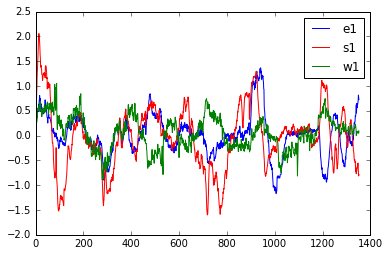

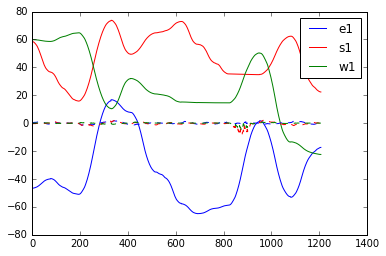

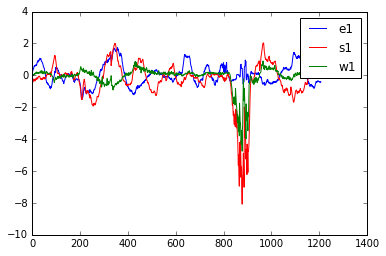

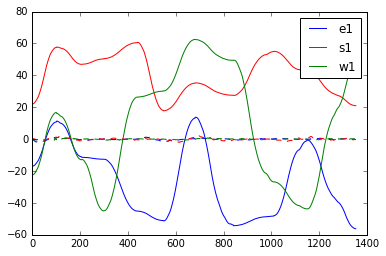

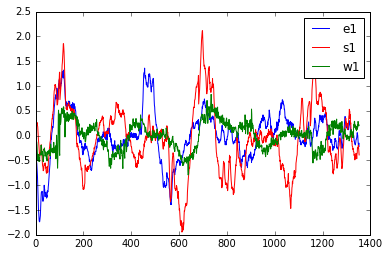

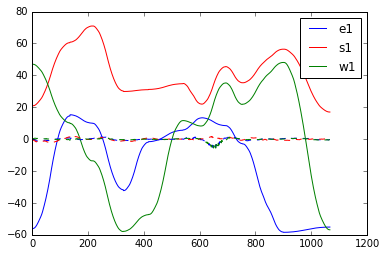

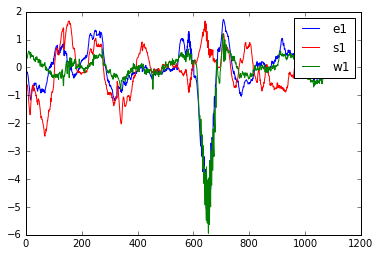

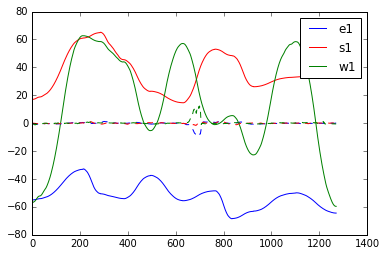

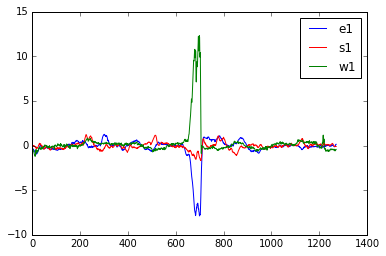

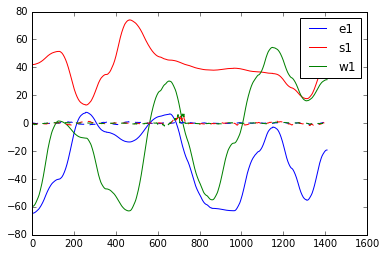

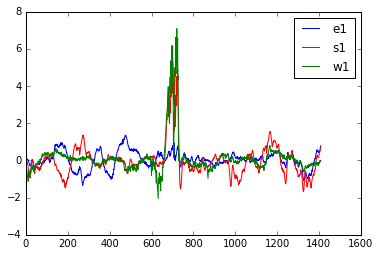

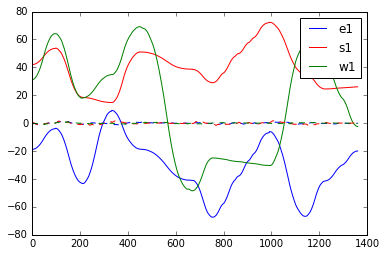

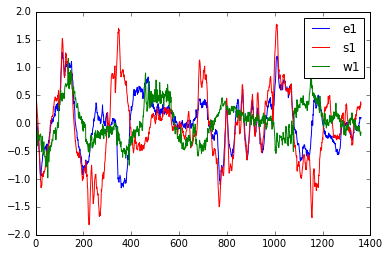

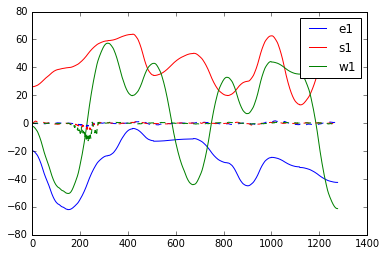

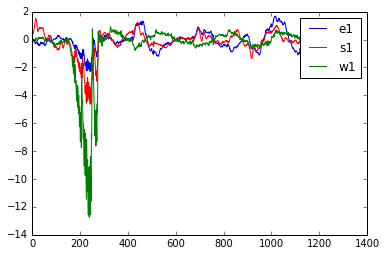

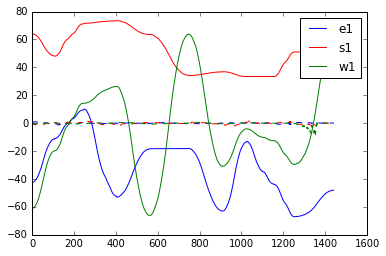

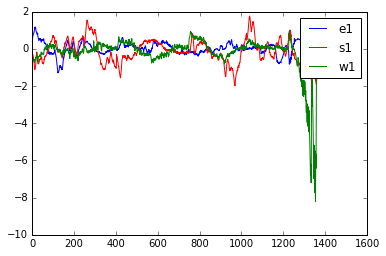

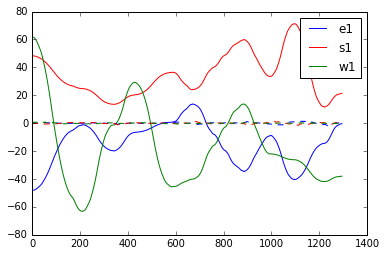

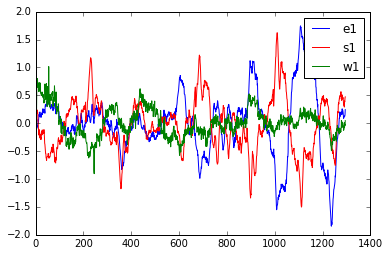

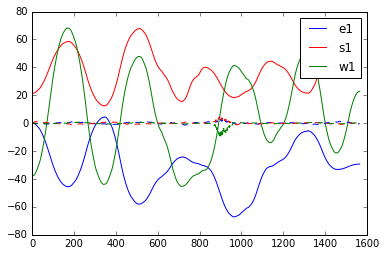

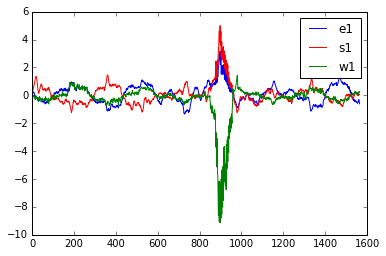

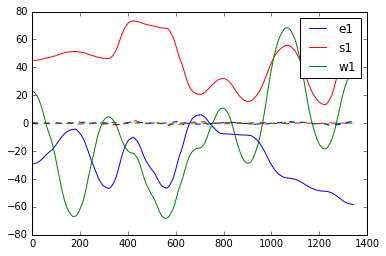

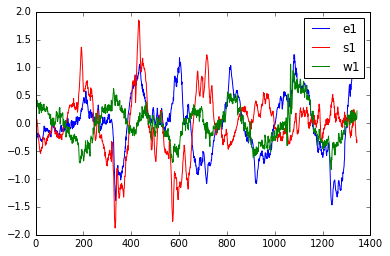

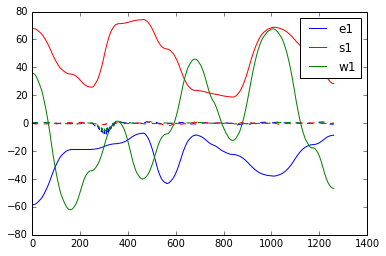

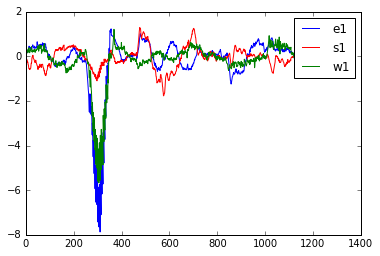

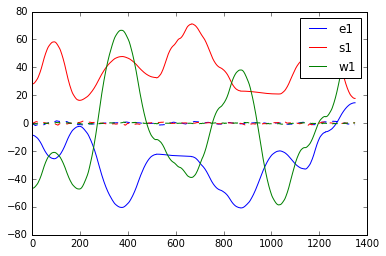

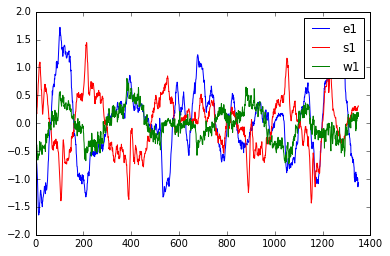

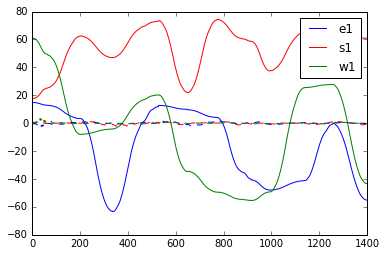

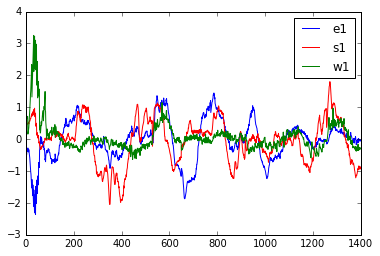

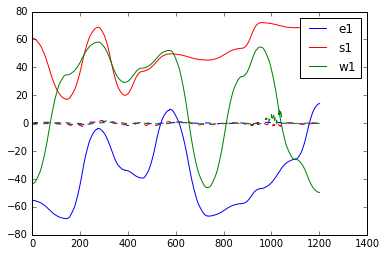

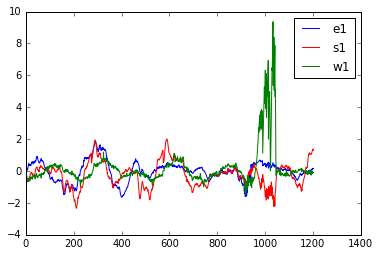

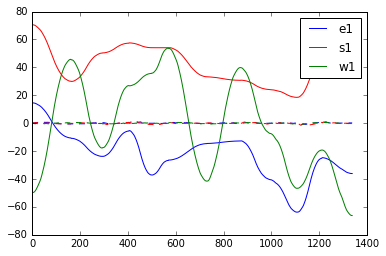

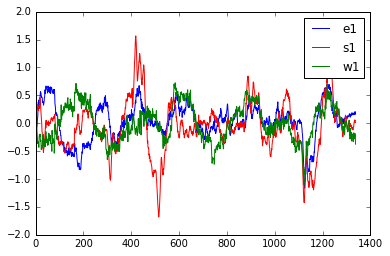

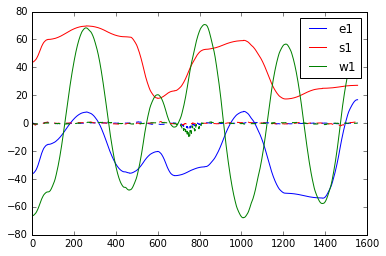

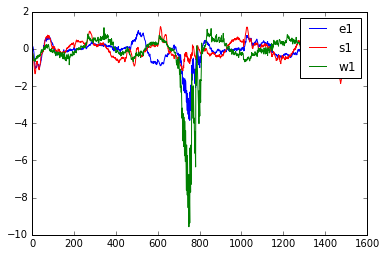

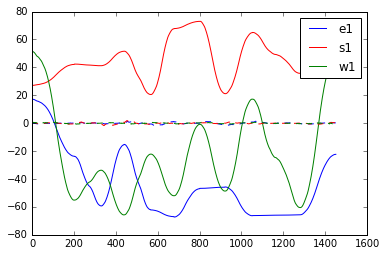

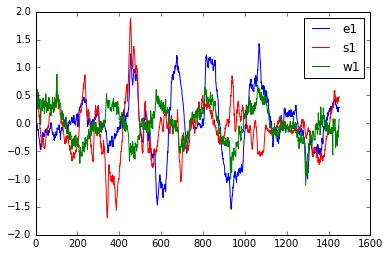

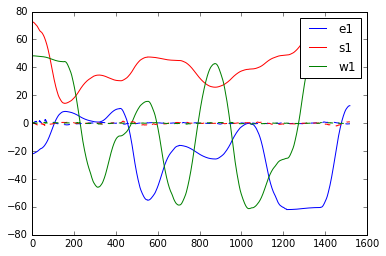

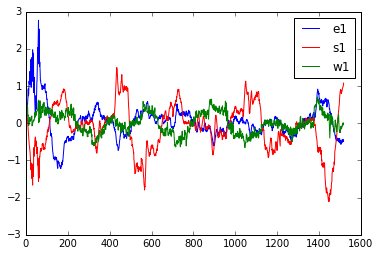

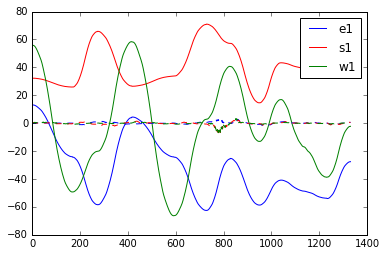

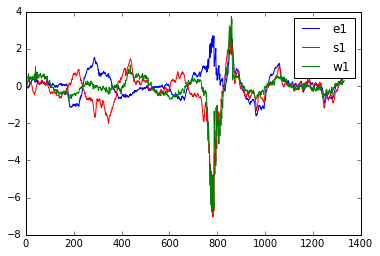

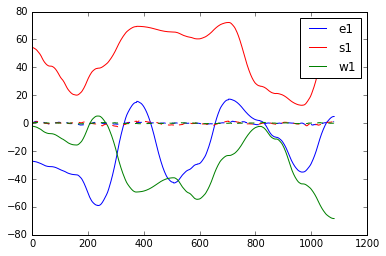

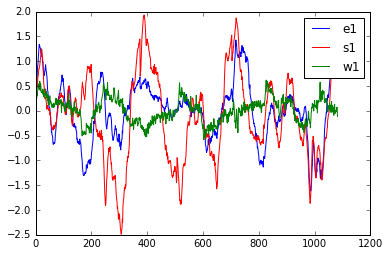

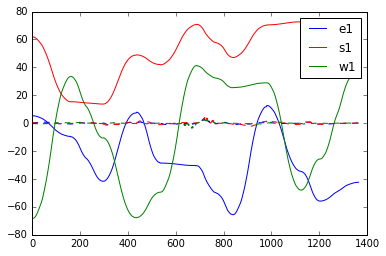

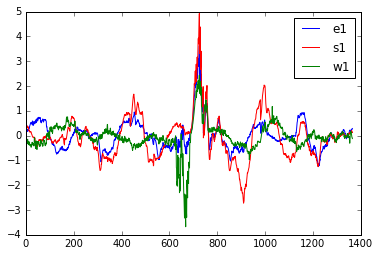

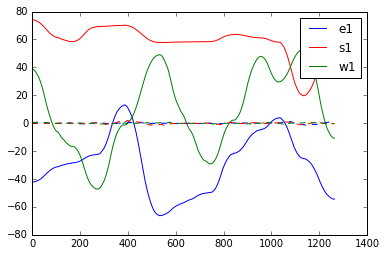

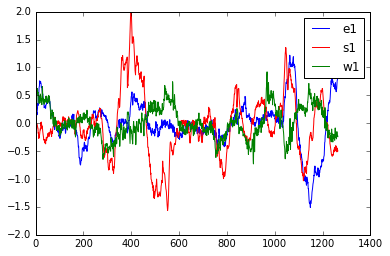

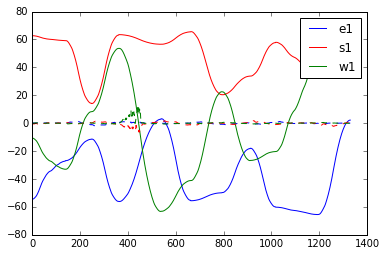

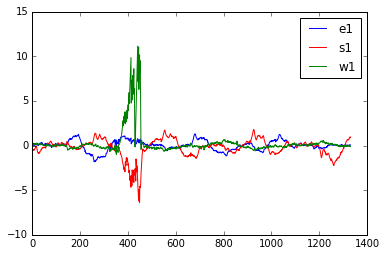

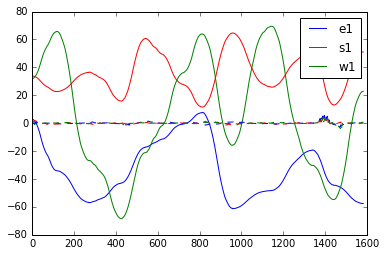

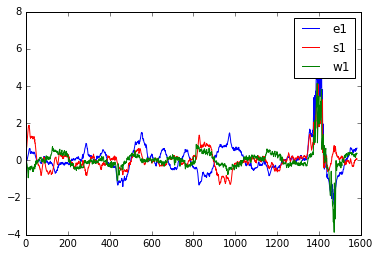

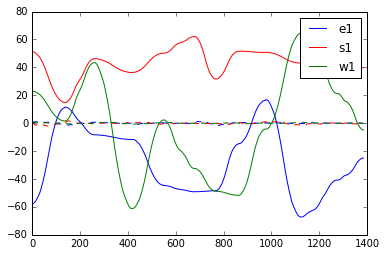

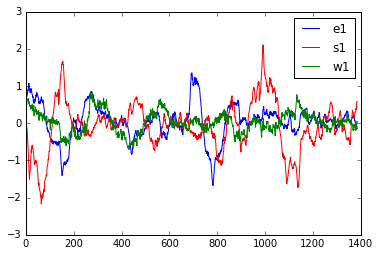

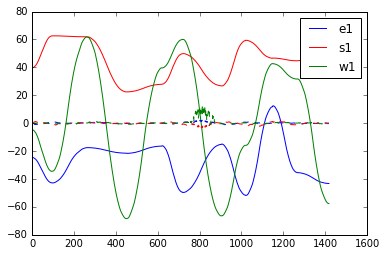

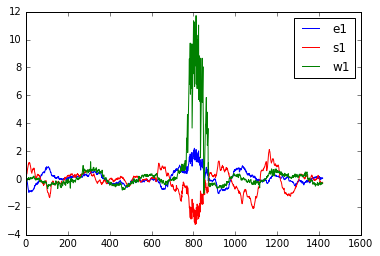

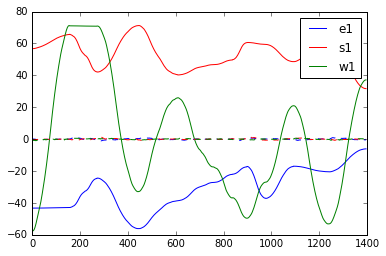

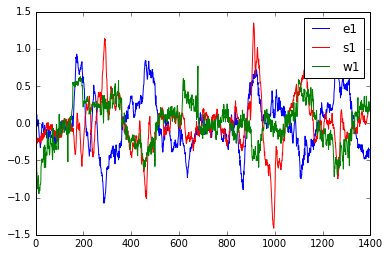

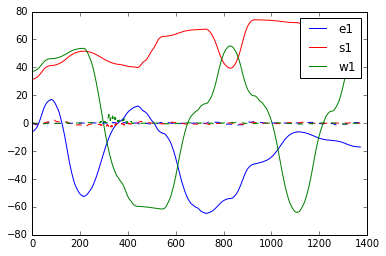

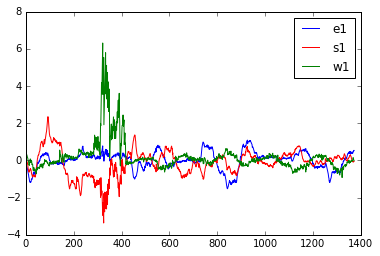

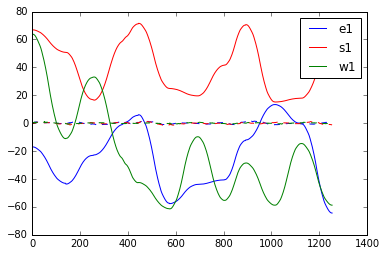

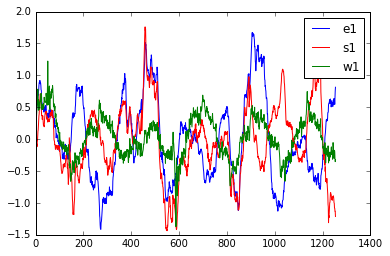

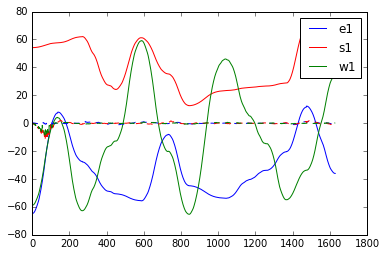

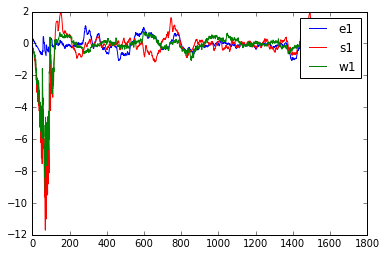

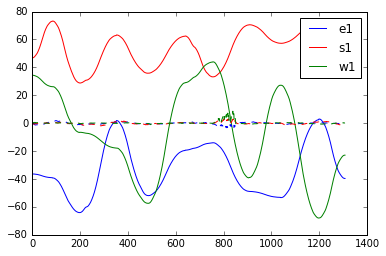

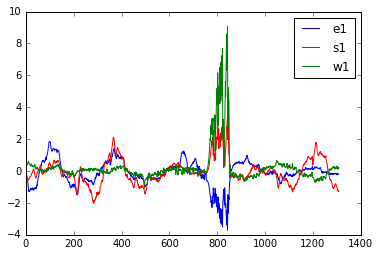

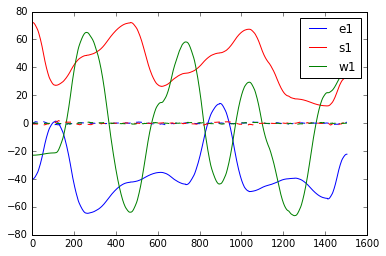

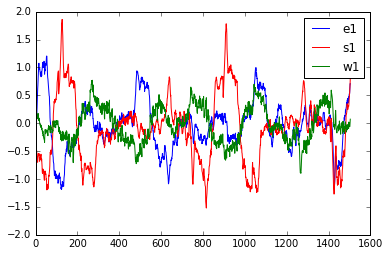

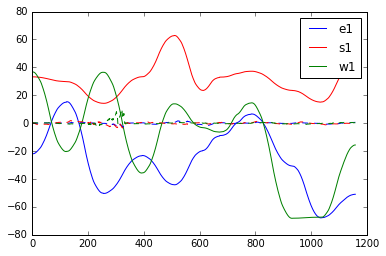

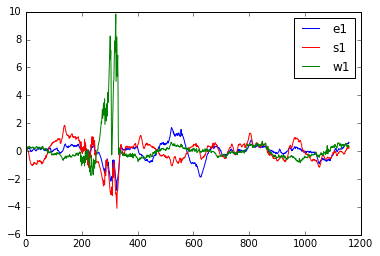

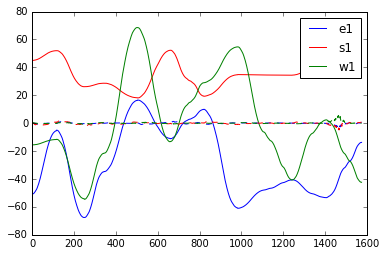

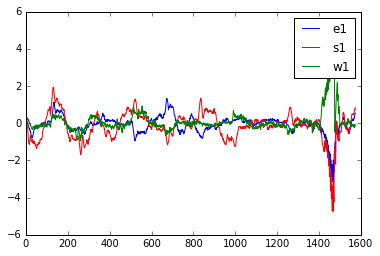

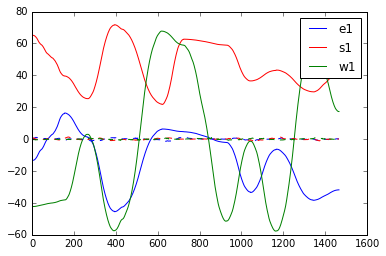

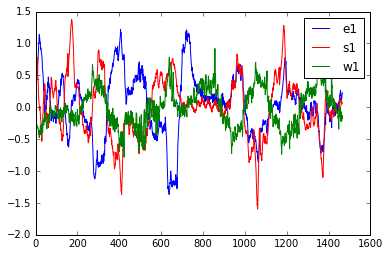

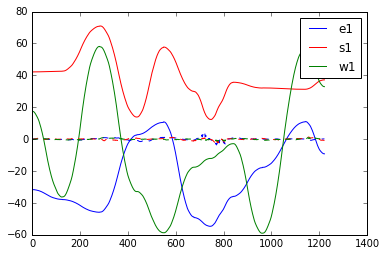

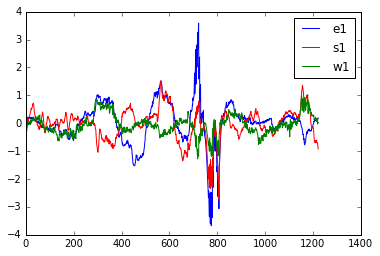

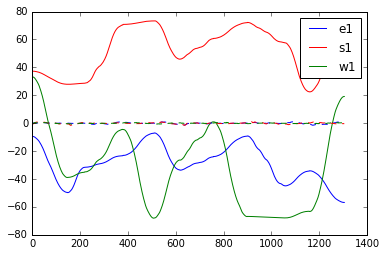

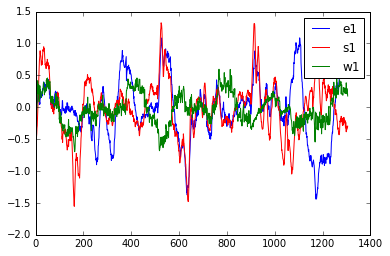

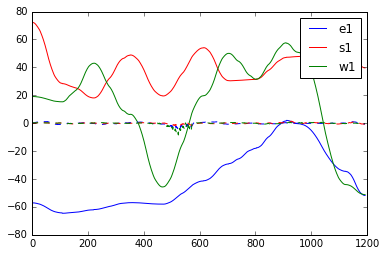

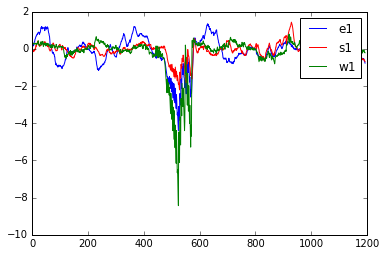

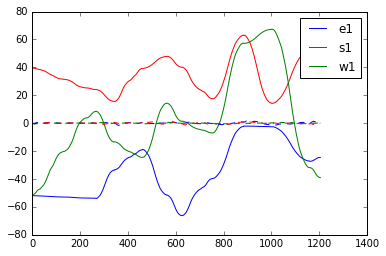

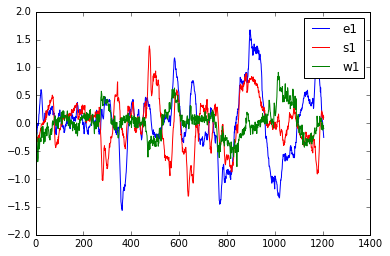

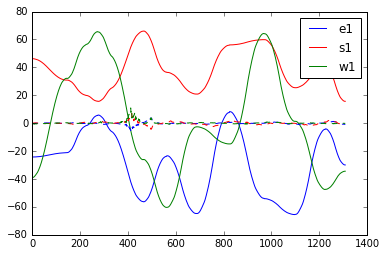

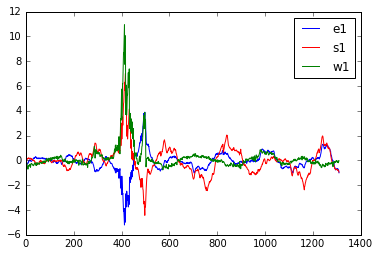

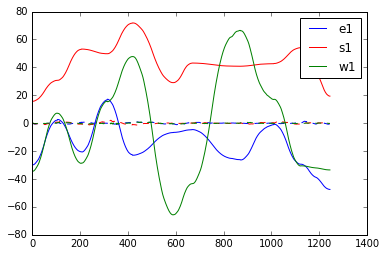

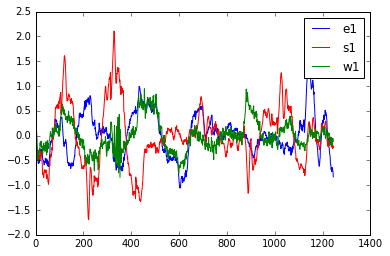

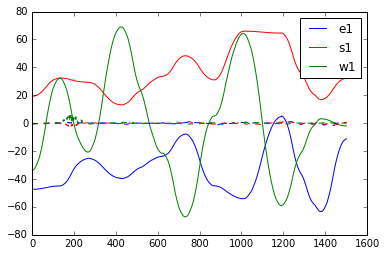

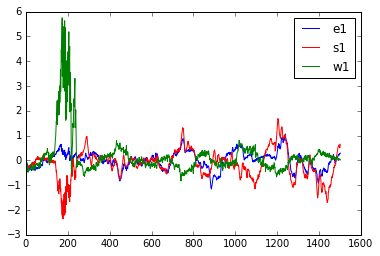

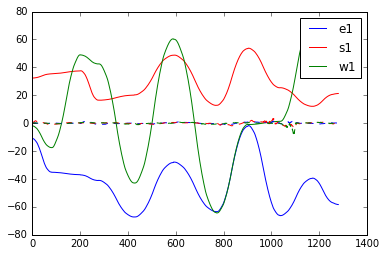

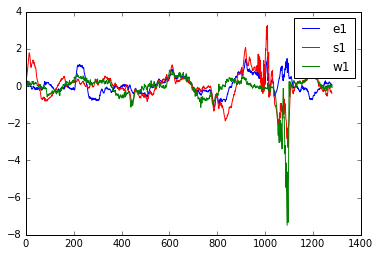

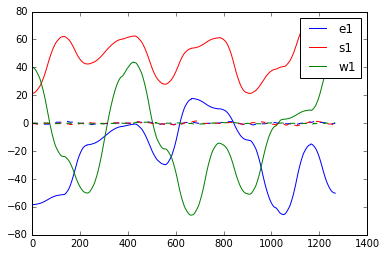

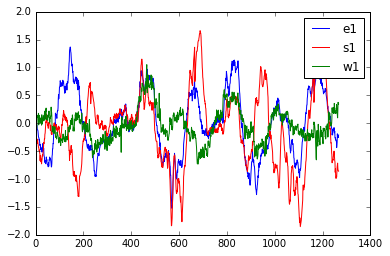

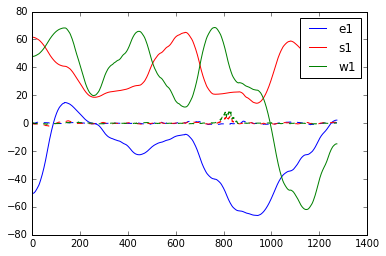

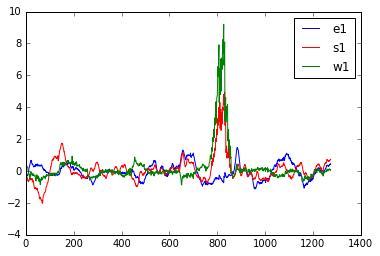

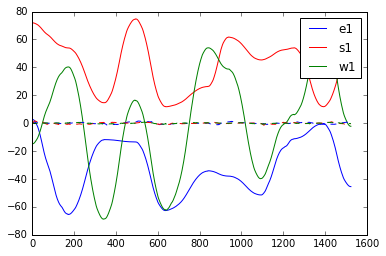

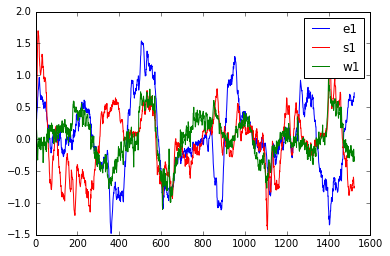

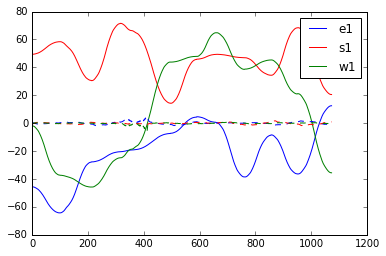

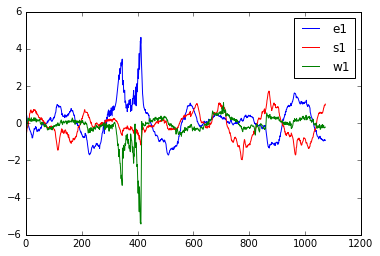

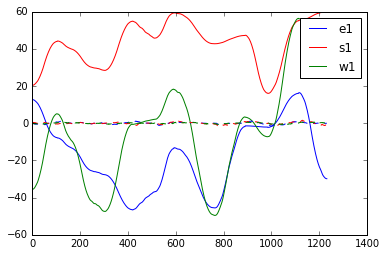

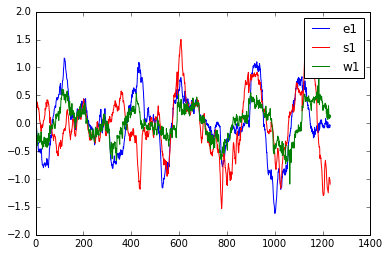

In [6]:
# plot commanded trajectory and error
joint_angles = {}
for file_iter in tqdmn(xrange(50), desc='Files read:'):
    plan = pickle.load(open(moveit_file + str(file_iter) + '.pkl', 'rb'))
    s1 = [row[1] for row in plan[1:]]
    e1 = [row[3] for row in plan[1:]]
    w1 = [row[5] for row in plan[1:]]
    plt.figure(file_iter)
    plt.plot(np.array(s1)*180/np.pi, 'b')
    plt.plot(np.array(e1)*180/np.pi, 'r')
    plt.plot(np.array(w1)*180/np.pi, 'g')
    plt.plot(np.array(err[file_iter]['e1'])*180./np.pi, 'b--')
    plt.plot(np.array(err[file_iter]['s1'])*180./np.pi, 'r--')
    plt.plot(np.array(err[file_iter]['w1'])*180./np.pi, 'g--')
    plt.legend(['e1', 's1', 'w1'])
    plt.show()
    plt.figure(50+file_iter)
    plt.plot(np.array(err[file_iter]['e1'])*180./np.pi, 'b')
    plt.plot(np.array(err[file_iter]['s1'])*180./np.pi, 'r')
    plt.plot(np.array(err[file_iter]['w1'])*180./np.pi, 'g')
    plt.legend(['e1', 's1', 'w1'])
    plt.show()

In [13]:
error_e1 = [abs(value) for value in row['e1'] for row in err]
error_s1 = [abs(value) for value in row['s1'] for row in err]
error_w1 = [abs(value) for value in row['w1'] for row in err]
error_traj = [i+j+k for (i,j,k) in zip(error_e1, error_s1, error_w1)]

print "Average e1 error: " + str(np.average(np.array(error_e1))*180/np.pi)
print "Average s1 error: " + str(np.average(np.array(error_s1))*180/np.pi)
print "Average w1 error: " + str(np.average(np.array(error_w1))*180/np.pi)
print "Average trajectory error: " + str(np.median(np.array(error_traj))*180/np.pi)
# print "Median e1 error: " + str(np.median(np.array(error_e1))*180/np.pi)
# print "Median s1 error: " + str(np.median(np.array(error_s1))*180/np.pi)
# print "Median w1 error: " + str(np.median(np.array(error_w1))*180/np.pi)
# print "Median trajectory error: " + str(np.median(np.array(error_traj))*180/np.pi)

Average e1 error: 0.4049677104651966
Average s1 error: 0.4309950468434822
Average w1 error: 0.24767543730099081
Average trajectory error: 1.028668369157898
